In [1]:
import sys
sys.path.extend(['..'])

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import stan
import json
from pathlib import Path
from tqdm.auto import trange

import nest_asyncio
nest_asyncio.apply()

%matplotlib inline

In [3]:
demo_distribution, demo_lambda = 'banana', 2.0
stan_file = Path('..') / demo_distribution / (demo_distribution + '.stan')
data_file = Path('..') / demo_distribution / 'data.json'
nuts_csv = Path('..') / demo_distribution / 'nuts_1.csv'
advi_csv = Path('..') / demo_distribution / 'advi600.csv'
isvi_csv = Path('..') / demo_distribution / 'isvi_2.0_1.csv'

assert stan_file.exists()
assert nuts_csv.exists()
assert advi_csv.exists()
assert isvi_csv.exists()

Create a stan model we can query in python

In [4]:
%%capture
with open(stan_file, 'r') as f:
    data = json.load(data_file) if data_file.exists() else {}
    stan_model = stan.build(f.read(), data=data)

load NUTS results and use them to define bounds on the space

In [5]:
def samples_to_limits(samples):
    lo_hi = np.array([samples.min(), samples.max()])
    midpoint = np.mean(lo_hi)
    return midpoint + 1.1 * (lo_hi - midpoint)

nuts_data = pd.read_csv(nuts_csv, comment='#')
samples = nuts_data[list(stan_model.param_names)]
ranges = {k: samples_to_limits(samples[k]) for k in stan_model.param_names}
grids = {k: np.linspace(*r, 100) for k, r in ranges.items()}

In [6]:
xx, yy = np.meshgrid(grids['x'], grids['y'])
lp = np.zeros(xx.size)
for i in trange(xx.size):
    lp[i] = stan_model.log_prob([xx.flatten()[i], yy.flatten()[i]])
lp = np.reshape(lp, xx.shape)

  0%|          | 0/10000 [00:00<?, ?it/s]

## Animate sampling

In [7]:
from matplotlib import animation
from IPython.display import HTML
from matplotlib import cm as cmap

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8))

n_samples_plot = 300
lines = [None]*2

progbar = trange(n_samples_plot, desc='Frames', leave=False)

def init():
    ax[0].imshow(np.exp(lp), origin='lower', extent=(xx.min(), xx.max(), yy.min(), yy.max()))
    ax[1].plot(samples.x[:n_samples_plot], color=cmap.tab10(0.0), alpha=0.2)
    ax[1].plot(samples.y[:n_samples_plot], color=cmap.tab10(0.1), alpha=0.2)
    ax[1].set_xlabel('samples')
    ax[1].set_title('traces from NUTS')
    lines[0], = ax[1].plot([1], samples.x[:1], marker='.', color=cmap.tab10(0.0), linestyle='', label='x')
    lines[1], = ax[1].plot([1], samples.y[:1], marker='.', color=cmap.tab10(0.1), linestyle='', label='y')
    ax[1].legend(loc='upper right')
    return fig,

def update(i):
    progbar.update(1)
    ax[0].plot(samples.x[i], samples.y[i], '.r', alpha=0.5)
    lines[0].set_data(1+np.arange(i+1), samples.x[:i+1])
    lines[1].set_data(1+np.arange(i+1), samples.y[:i+1])
    return fig,

anim = animation.FuncAnimation(fig, update, frames=n_samples_plot, init_func=init)
anim.save("nuts.gif", writer=animation.PillowWriter(fps=30), dpi=300)
plt.close(fig)

Frames:   0%|          | 0/300 [00:00<?, ?it/s]

![NUTS animated](nuts.gif)

## Animate VI

Note: Stan ADVI does not natively print out its optimization trajectory anywhere. I hacked it in with some `std::cout` then filtered to CSV using
```
$ ./banana variational output file=advi.csv > tmp.txt  
$ cat tmp.txt | grep -A 3 ADVI | sed 's/\[ADVI PARAMS\]//' | head -n 3000 > advi600.csv
```
The 3000 lines come from the fact that there are 4 parameters plus a '--' for each iteration, so 5 lines define 1 iteration. After more messing around with find/replace I made it into a valid csv called `advi600.csv`

In [10]:
advi_optim_steps = pd.read_csv(Path('..') / demo_distribution / 'advi600.csv').to_numpy()

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8))

n_advi_plot = 600
skip = 2

ellipse = [None]
lines = [None]*4

progbar = trange(n_advi_plot, desc='Frames', leave=False)


def diag_ellipse(theta):
    mu = theta[:2]
    sigma = np.exp(theta[2:])
    t = np.linspace(0, 2*np.pi)
    uv = np.stack([np.cos(t), np.sin(t)], axis=1)
    return (mu + sigma * uv).T


def init():
    ax[0].imshow(np.exp(lp), origin='lower', extent=(xx.min(), xx.max(), yy.min(), yy.max()))
    ellipse[0], = ax[0].plot(*diag_ellipse(advi_optim_steps[0]), '-r')
    ax[1].plot(advi_optim_steps[:n_advi_plot, 0], color=cmap.tab10(0.0), alpha=0.2)
    ax[1].plot(advi_optim_steps[:n_advi_plot, 1], color=cmap.tab10(0.1), alpha=0.2)
    ax[1].plot(advi_optim_steps[:n_advi_plot, 2], color=cmap.tab10(0.2), alpha=0.2)
    ax[1].plot(advi_optim_steps[:n_advi_plot, 3], color=cmap.tab10(0.3), alpha=0.2)
    ax[1].set_xlabel('optimization steps')
    ax[1].set_title('optimization trace from ADVI')
    lines[0], = ax[1].plot([1], advi_optim_steps[0,0], marker='.', color=cmap.tab10(0.0), linestyle='', label='$\mu_x$')
    lines[1], = ax[1].plot([1], advi_optim_steps[0,1], marker='.', color=cmap.tab10(0.1), linestyle='', label='$\mu_y$')
    lines[2], = ax[1].plot([1], advi_optim_steps[0,2], marker='.', color=cmap.tab10(0.2), linestyle='', label='$\omega_x$')
    lines[3], = ax[1].plot([1], advi_optim_steps[0,3], marker='.', color=cmap.tab10(0.3), linestyle='', label='$\omega_x$')
    ax[1].legend(loc='upper right')
    return fig,


def update(i):
    progbar.update(skip)
    ellipse[0].set_data(*diag_ellipse(advi_optim_steps[i*skip]))
    lines[0].set_data(1+i*skip, advi_optim_steps[i*skip, 0])
    lines[1].set_data(1+i*skip, advi_optim_steps[i*skip, 1])
    lines[2].set_data(1+i*skip, advi_optim_steps[i*skip, 2])
    lines[3].set_data(1+i*skip, advi_optim_steps[i*skip, 3])
    return fig,

anim = animation.FuncAnimation(fig, update, frames=n_advi_plot//skip, init_func=init)
anim.save("advi.gif", writer=animation.PillowWriter(fps=30), dpi=300)
plt.close(fig)

Frames:   0%|          | 0/600 [00:00<?, ?it/s]

![ADVI animated](advi.gif)

## ISVI animation

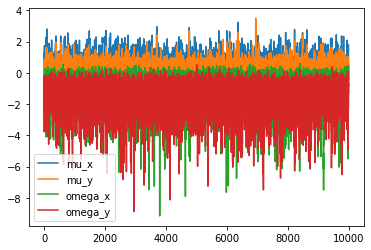

In [15]:
isvi_data = pd.read_csv(isvi_csv, comment='#')
isvi_data[['mu_x', 'mu_y', 'omega_x', 'omega_y']].plot()
isvi_samples = isvi_data[['mu_x', 'mu_y', 'omega_x', 'omega_y']].to_numpy()

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(5, 8))

n_samples_plot = 300
lines = [None]*4

progbar = trange(n_samples_plot, desc='Frames', leave=False)

def init():
    ax[0].imshow(np.exp(lp), origin='lower', extent=(xx.min(), xx.max(), yy.min(), yy.max()))
    ax[0].plot(*diag_ellipse(isvi_samples[0]), '-r', alpha=0.3)
    ax[1].plot(isvi_samples[:n_samples_plot, 0], color=cmap.tab10(0.0), alpha=0.2)
    ax[1].plot(isvi_samples[:n_samples_plot, 1], color=cmap.tab10(0.1), alpha=0.2)
    ax[1].plot(isvi_samples[:n_samples_plot, 2], color=cmap.tab10(0.2), alpha=0.2)
    ax[1].plot(isvi_samples[:n_samples_plot, 3], color=cmap.tab10(0.3), alpha=0.2)
    ax[1].set_xlabel('samples')
    ax[1].set_title('Our Method')
    lines[0], = ax[1].plot([1], isvi_samples[0,0], marker='.', color=cmap.tab10(0.0), linestyle='', label='$\mu_x$')
    lines[1], = ax[1].plot([1], isvi_samples[0,1], marker='.', color=cmap.tab10(0.1), linestyle='', label='$\mu_y$')
    lines[2], = ax[1].plot([1], isvi_samples[0,2], marker='.', color=cmap.tab10(0.2), linestyle='', label='$\omega_x$')
    lines[3], = ax[1].plot([1], isvi_samples[0,3], marker='.', color=cmap.tab10(0.3), linestyle='', label='$\omega_x$')
    return fig,

def update(i):
    progbar.update(1)
    ax[0].plot(*diag_ellipse(isvi_samples[i]), '-r', alpha=0.3)
    lines[0].set_data(1+np.arange(i+1), isvi_samples[:i+1, 0])
    lines[1].set_data(1+np.arange(i+1), isvi_samples[:i+1, 1])
    lines[2].set_data(1+np.arange(i+1), isvi_samples[:i+1, 2])
    lines[3].set_data(1+np.arange(i+1), isvi_samples[:i+1, 3])
    return fig,

anim = animation.FuncAnimation(fig, update, frames=n_samples_plot, init_func=init)
anim.save("isvi.gif", writer=animation.PillowWriter(fps=30), dpi=300)
plt.close(fig)

Frames:   0%|          | 0/300 [00:00<?, ?it/s]

![ISVI animated](isvi.gif)